In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

# Create monthly composites from S1, S2 and LS8

In [2]:
from pathlib import Path
import xarray as xr
# Define dataset file paths
DATA_DIR = Path('output/')
DATASETS = {
    'l8': DATA_DIR / 'l8_wofs.nc',
    's1': DATA_DIR / 's1_water.nc',
}

datasets = {name: xr.open_dataset(path).sortby('time') for name, path in DATASETS.items()}

datasets['s2'] = xr.concat([xr.open_dataset(DATA_DIR / 'wofs_s2ab_cloudless_2016.nc'),
                            xr.open_dataset(DATA_DIR / 'wofs_s2ab_cloudless_2017.nc'),
                            xr.open_dataset(DATA_DIR / 'wofs_s2ab_cloudless_2018.nc')], dim='time')

print('Loaded datasets: {}'.format(', '.join(datasets.keys())))

Loaded datasets: l8, s1, s2


Each xarray contains a variable called `wofs` that houses water classifications from the classifiers. Values in these xarray assume one of three values. `1`,`0` for water and not-water as well as `nan` values for areas occluded by cloud or are missing data.  

## Naive Mixed annual composite

In [3]:
for key in datasets.keys():
    datasets[key] = datasets[key].isel(time=(datasets[key].wofs.isnull().groupby('time').mean()<0.9).values)

In [4]:
import functools as fct
merged = fct.reduce(lambda ds_a, ds_b: ds_a.merge(ds_b), datasets.values())

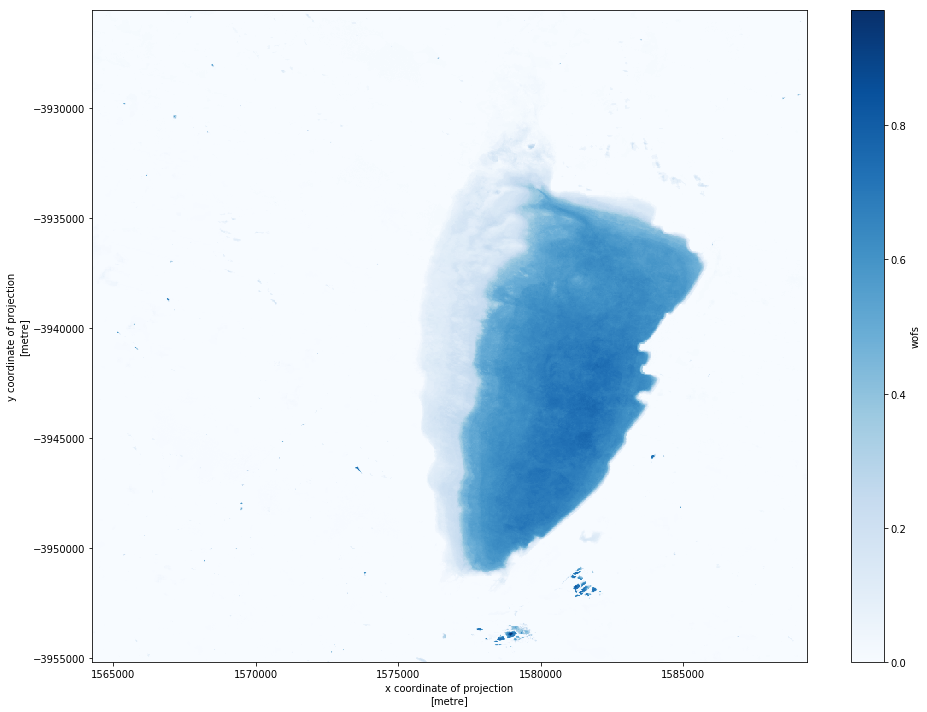

In [5]:
plt.figure(figsize = (16,12))
merged.mean(dim = "time", skipna = True).wofs.plot(cmap = "Blues")

# Building an Integrated Profile of Lake George

In [6]:
from segment import boolean_xarray_min_size_segmentation_filter  
import xarray as xr  

def extract_large_body_from_boolean_xarray( da:xr.DataArray,
                                            frequency_percentile:float = 0.0625,
                                            min_number_of_pixels:int = 1000):

    body = (da.mean(dim = "time") > frequency_percentile)
    return boolean_xarray_min_size_segmentation_filter(body, min_size= min_number_of_pixels)    

In [7]:
george = extract_large_body_from_boolean_xarray(merged.wofs)

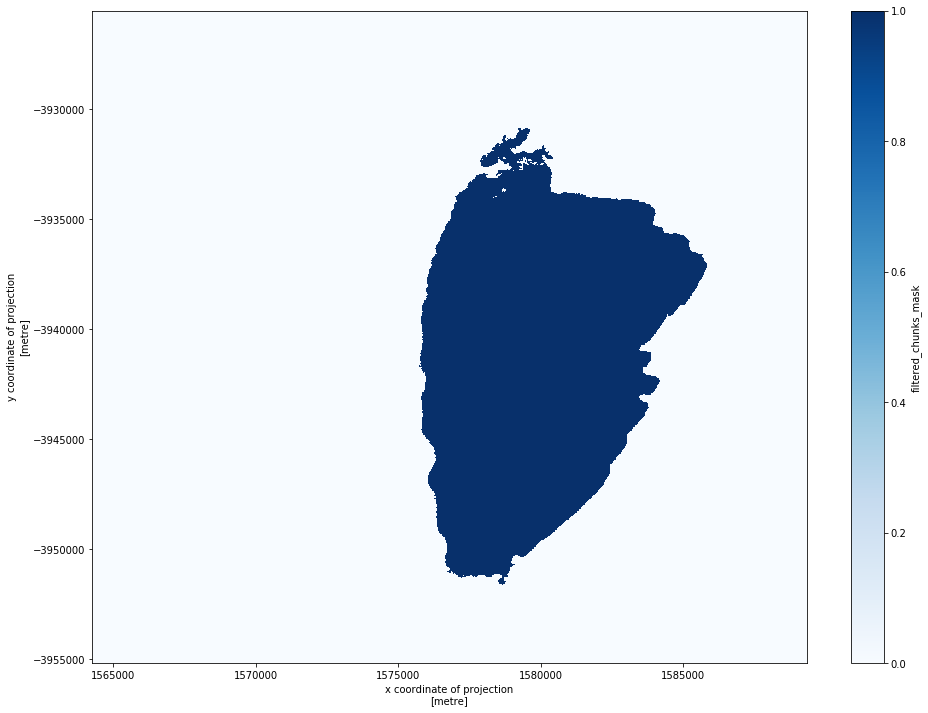

In [8]:
george.plot(cmap = "Blues", figsize=(16,12))

## Monthly Temporal Aggregation

In [9]:
fused_resample = merged.resample(time = "M").mean(skipna = True)
fused_resample = (fused_resample>=0.5)*1.

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


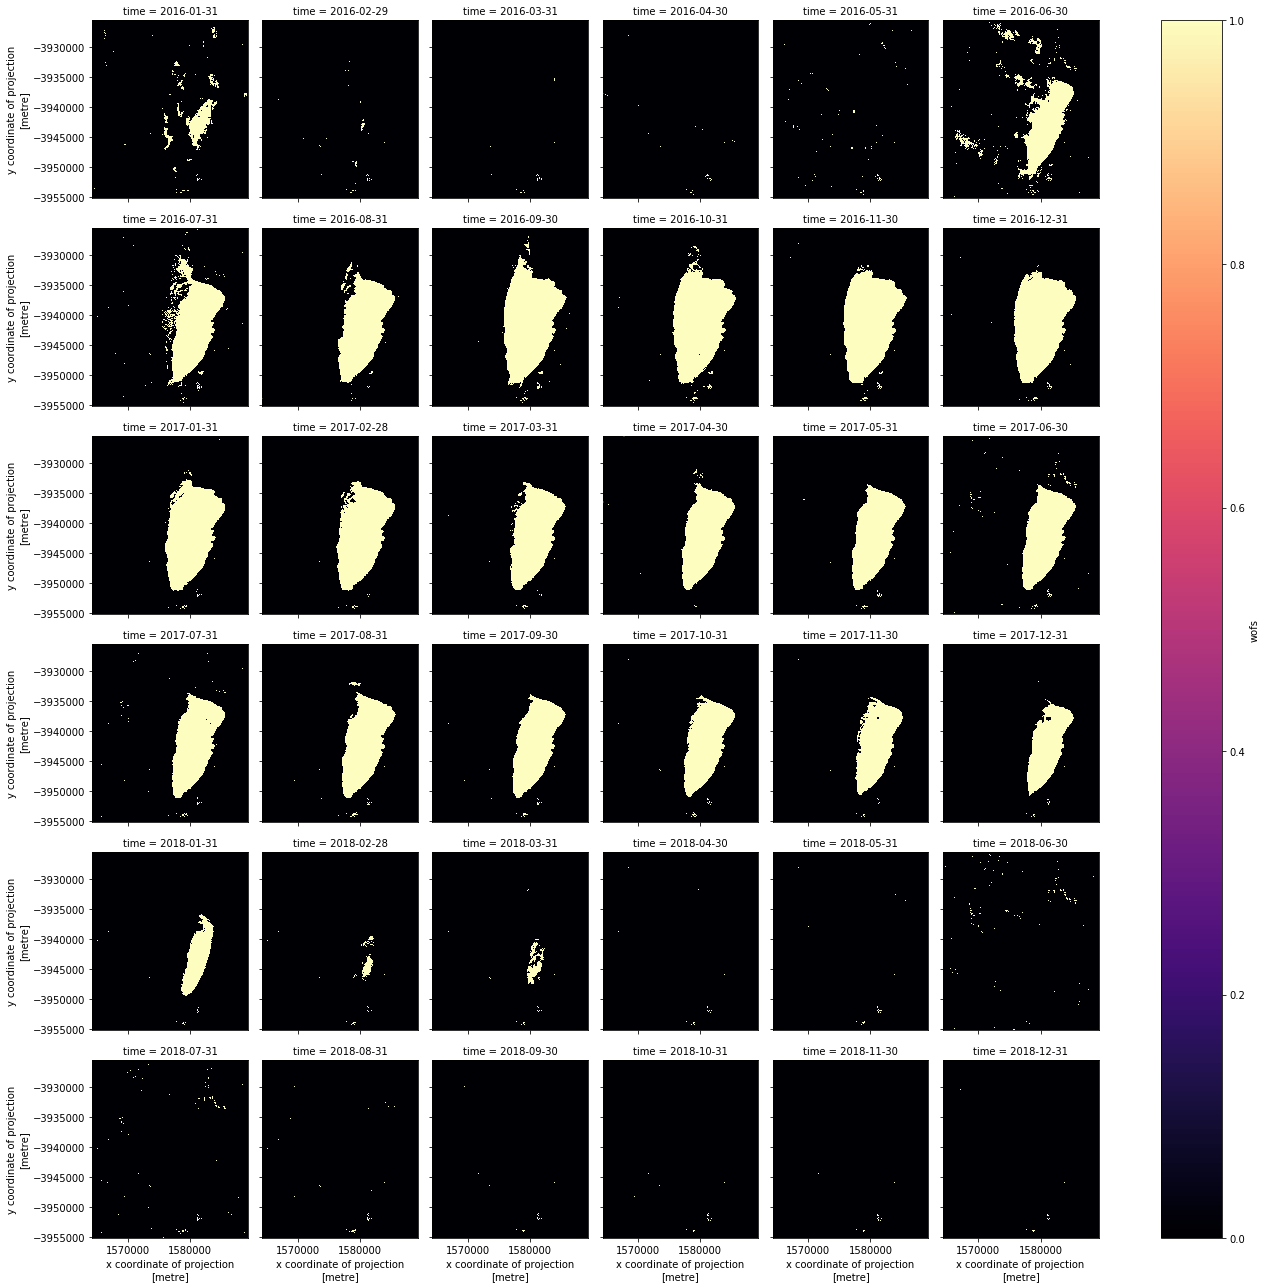

In [10]:
fused_resample.wofs.plot(col='time',col_wrap=6, cmap = "magma")

## Lake George Fullness

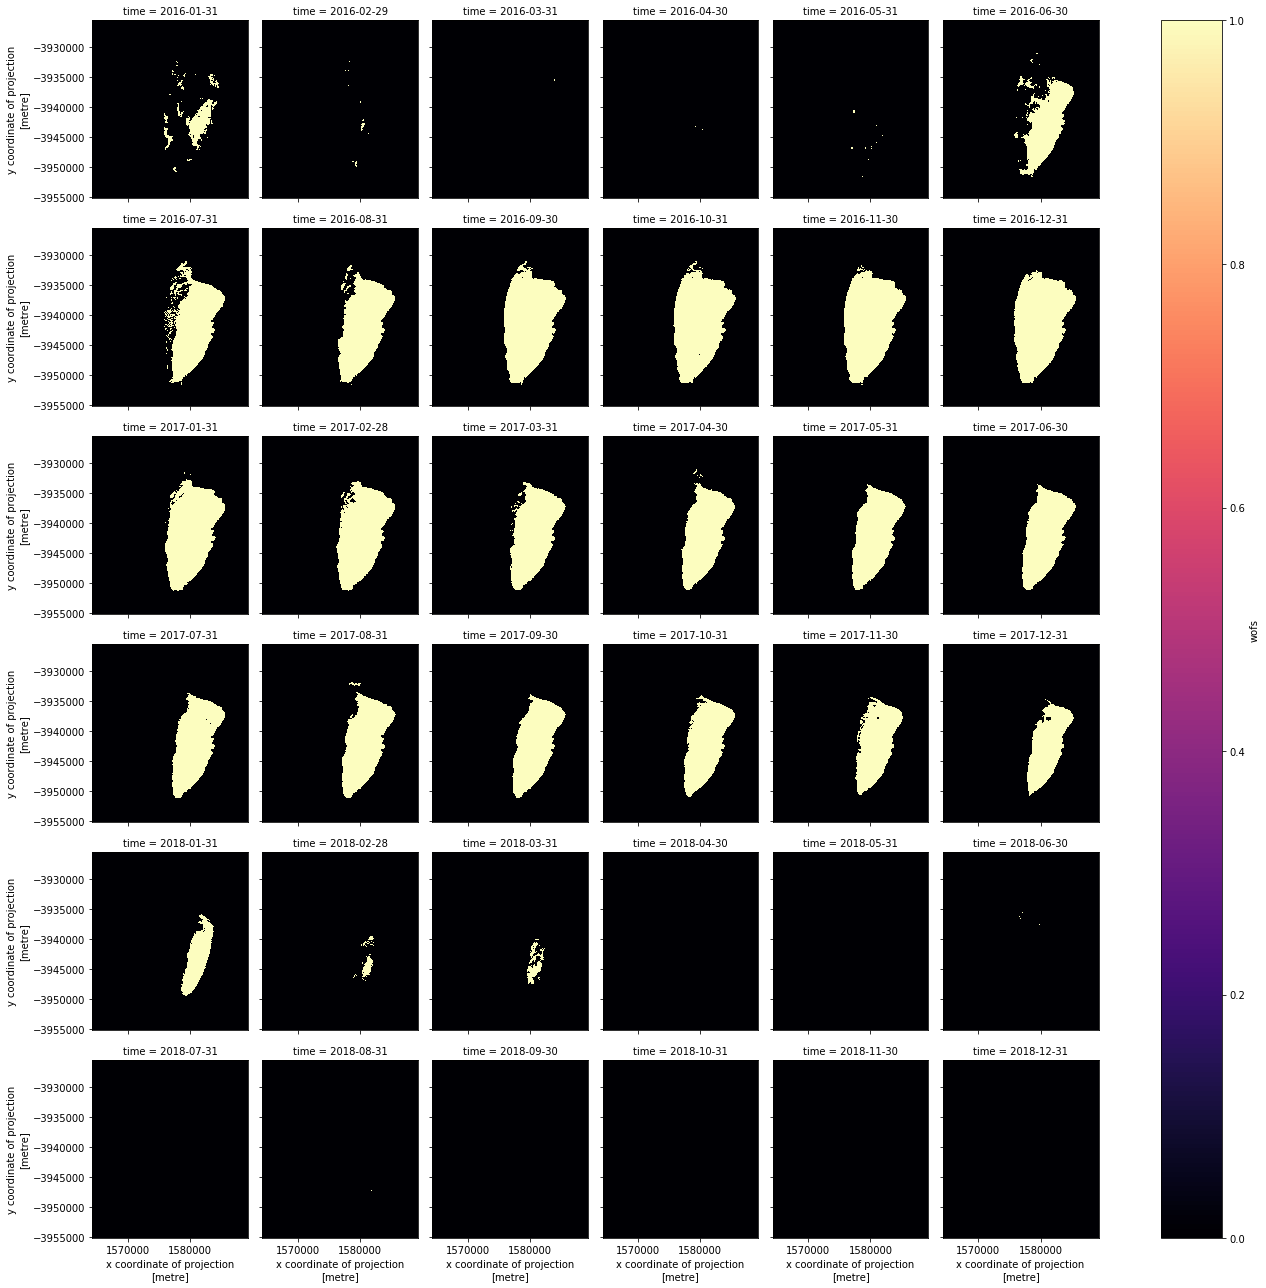

In [11]:
fused_resample.where(george, 0).wofs.plot(col='time',col_wrap=6, cmap = "magma")

In [12]:
#fused_resample.where(george).wofs.plot(col='time',col_wrap=4, cmap = "magma")

In [13]:
monthly_l8 = datasets["l8"].resample(time = "M").mean(skipna = True)
monthly_s1 = datasets["s1"].resample(time = "M").mean(skipna = True)
monthly_s2 = datasets["s2"].resample(time = "M").mean(skipna = True)

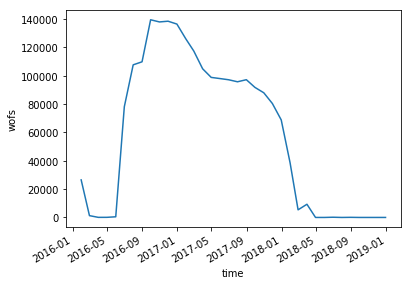

In [14]:
max_sizes = fused_resample.where(george).wofs.groupby('time').sum()
max_sizes.plot()

In [15]:
max_sizes_l8 = monthly_l8.where(george).wofs.groupby('time').sum()
max_sizes_s1 = monthly_s1.where(george).wofs.groupby('time').sum()
max_sizes_s2 = monthly_s2.where(george).wofs.groupby('time').sum()

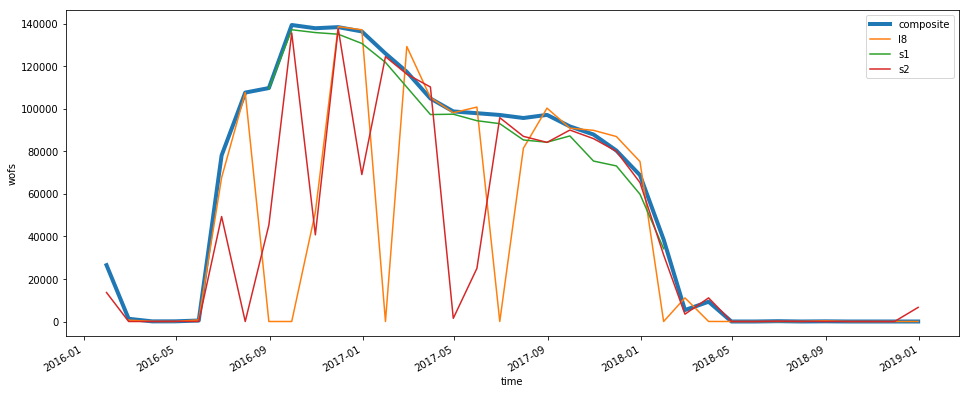

In [16]:
max_sizes.plot(figsize=(16,6),label='composite', linewidth=4)
max_sizes_l8.plot(label='l8')
max_sizes_s1.plot(label='s1')
max_sizes_s2.plot(label='s2')
plt.legend()